In [158]:
import pandas as pd
import numpy as np
import nltk
import requests
import re
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
import matplotlib.lines as mlines
import seaborn as sns

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

import sddk

In [3]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:
conf = sddk.configure()

# (1) read the file and parse its content
file_data = conf[0].get(conf[1] + "ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)
# (5) establish connection with spreadsheets specified by their url
occupations = gc.open_by_url("https://docs.google.com/spreadsheets/d/1nONTEwp42CVnq3iCiONrFbJedIcYtBV-l4Bil5mU7Eo/edit?usp=sharing")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [4]:
# login to our project folder, owned by my AU account 648597@au.dk, using my account at another institution
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [5]:
# read edh dataset
publicfolder = "b6b6afdb969d378b70929e86e58ad975"
EDH = sddk.read_file("EDH_text_cleaned_2021-01-21.json", "df", publicfolder)
EDH.head(5)

reading file located in a public folder


,responsible_individual,type_of_inscription,letter_size,not_after,literature,work_status,height,diplomatic_text,people,depth,...,clean_text_conservative,clean_text_interpretive_word,clean_text_interpretive_sentence,findspot,year_of_find,present_location,religion,geography,social_economic_legal_history,military
0,Feraudi,epitaph,3.2-2 cm,0130,"AE 1983, 0192.; M. Annecchino, Puteoli 4/5, 19...",provisional,33 cm,D M / NONIAE P F OPTATAE / ET C IVLIO ARTEMONI...,"[{'name': 'Noniae P.f. Optatae', 'cognomen': '...",2.7 cm,...,D M Noniae P f Optatae et C Iulio Artemoni par...,Dis Manibus Noniae Publi filiae Optatae et Cai...,Dis Manibus Noniae Publi filiae Optatae et Cai...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Feraudi,epitaph,4 cm,0200,"AE 1983, 0080. (A); A. Ferrua, RAL 36, 1981, 1...",no image,28 cm,C SEXTIVS PARIS / QVI VIXIT / ANNIS LXX,"[{'nomen': 'Sextius', 'praenomen': 'C.', 'pers...",NaN,...,C Sextius Paris qui vixit annis LXX,Caius Sextius Paris qui vixit annis LXX,Caius Sextius Paris qui vixit annis LXX,"Via Nomentana, S. Alessandro, Kirche",1937,NaN,NaN,NaN,NaN,NaN
2,Feraudi,honorific inscription,4.5-3 cm,0170,"AE 1983, 0518. (B); J. González, ZPE 52, 1983,...",provisional,(37) cm,[ ]VMMIO [ ] / [ ]ISENNA[ ] / [ ] XV[ ] / [ ] / [,"[{'nomen': 'Mummius+', 'gender': 'male', 'prae...",(12) cm,...,ummio isenna Xv,Publio Mummio Publi filio Galeria Sisennae Rut...,Publio Mummio Publi filio Galeria Sisennae Rut...,NaN,before 1975,"Sevilla, Privatbesitz",NaN,NaN,NaN,NaN
3,Gräf,votive inscription,2.5 cm,0200,"AE 1983, 0533. (B); A.U. Stylow, Gerión 1, 198...",checked with photo,(39) cm,[ ]AVS[ ]LLA / M PORCI NIGRI SER / DOMINAE VEN...,[{'name': '[---?]AV(?)S(?)[---]L(?)L(?)A M. Po...,18 cm,...,AVSLLA M Porci Nigri ser dominae Veneri aram p...,AVS LLA Marci Porci Nigri serva dominae Veneri...,AVS LLA Marci Porci Nigri serva dominae Veneri...,NaN,before 1979,"Carcabuey, Grupo Escolar",names of pagan deities,NaN,NaN,NaN
4,Feraudi,epitaph,NaN,0200,"AE 1983, 0078. (B); A. Ferrua, RAL 36, 1981, 1...",no image,NaN,[ ] L SVCCESSVS / [ ] L L IRENAEVS / [ ] C L T...,"[{'person_id': '1', 'name': '[---]l. Successus...",NaN,...,l Successus L l Irenaeus C l Tyches unt renti f,libertus Successus Luci libertus Irenaeus Cai ...,libertus Successus Luci libertus Irenaeus Cai ...,Via Cupa (ehem. Vigna Nardi),NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# read edcs dataset
publicfolder = "1f5f56d09903fe259c0906add8b3a55e"
EDCS = sddk.read_file("EDCS_text_cleaned_2021-01-21.json", "df", publicfolder)
EDCS.head(5)

reading file located in a public folder


,EDCS-ID,publication,province,place,notes_dating,notes_references,notes_comments,inscription,inscription_stripped14,clean_text_interpretive_word,Links,language,dating from,dating to,status,Latitude,Longitude,photo,Material,Comment
0,EDCS-31400030,"CIL 03, 12297",Achaia,?,,,,Leius,Leius,Leius,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EDCS-24700151,"CIL 01, 02650 (p 1097) = IG-05-01, 00741 = ILL...",Achaia,Afesou,,,,// D(ecimi) Leivei D(ecimi) Leivei salve,// D(ecimi) Leivei D(ecimi) Leivei salve,Decimi Leivei Decimi Leivei salve,http://db.edcs.eu/epigr/partner.php?s_language...,GR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EDCS-24900077,"CIL 01, 00746 (p 944) = D 00867 = ILLRP 00374 ...",Achaia,Agia Triada / Merbaka / Midea,,,,Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...,Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...,Quinto Caecilio Cai filio Metello imperatori I...,http://db.edcs.eu/epigr/partner.php?s_language...,NaN,-68,-68,officium/professio; ordo senatorius; tituli ho...,37.6381128,22.8052991,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,NaN,NaN
3,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Agios Athanasios / Photike,,,,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et Piissimo Caesari domino nostro G...,http://db.edcs.eu/epigr/partner.php?s_language...,NaN,309,313,Augusti/Augustae; litterae erasae; ordo equest...,39.4512182,20.7667673,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,NaN,NaN
4,EDCS-55701593,"AE 2009, 01286a",Achaia,Agios Donatos / Photike,,,,Cn(aeus) Atei(us),Cn(aeus) Atei(us),Cnaeus Ateius,NaN,NaN,NaN,NaN,sigilla impressa; tituli fabricationis,39.4759759,20.5069076,NaN,opus figlinae,NaN


In [6]:
# read declined occupations
with open("../data/occups_declined_dict.json", "r") as fp:
    occups_declined_dict = json.load(fp)

In [7]:
# check that our occupations are properly arranged (from the longest...)
list(occups_declined_dict.keys())[:20]

['exactor auri argenti et aeris',
 'inclusor auri et gemmarum',
 'refector pectinarius',
 'instructor parietum',
 'tribor argentarius',
 'carrocarpentarius',
 'dactilidiogliphus',
 'manceps salinarum',
 'manceps thermarum',
 'aequator monetae',
 'conchyliolegulus',
 'orchestopolarius',
 'rhypararographus',
 'calciamentarius',
 'chorographarius',
 'diffusor oleari',
 'domnicomontanus',
 'faber tignuarii',
 'medicamentarius',
 'panchrestiarius']

# Function to extract occupations

In [8]:
def extract_occup_v1(inscription_text):
    occups_found = []
    for occup in occups_declined_dict.keys():
        for occup_morph in occups_declined_dict[occup]:
            try:
                occup_morph_N = inscription_text.lower().count(occup_morph)
                if occup_morph_N > 0:
                    occups_found.extend([occup] * occup_morph_N)
                    inscription_text = inscription_text.replace(occup_morph, "")
                
            except: pass
    return occups_found

In [30]:
def extract_occup(inscription_text):
    occups_found = []
    try:
        inscription_text = inscription_text.lower()
    except:
        inscription_text = ""
    for occup in occups_declined_dict.keys():
        for occup_morph in occups_declined_dict[occup]:
            try:
                if occup_morph in inscription_text: # first check it this way, otherwise skip
                    occup_morph_N = len(re.findall("(\W|^)" + occup_morph + "(\W|$)", inscription_text))
                    occups_found.extend([occup] * occup_morph_N)
                    inscription_text = inscription_text.replace(occup_morph, "")
            except: pass
    return occups_found

In [39]:
extract_occup("fdfsdf. Lotori,")

['lotorus']

# Test on a sample

In [22]:
# sample for testing
EDH_sample = EDH[:1000]
len(EDH_sample)

1000

In [23]:
%%time
EDH_sample["occups"] = EDH_sample["clean_text_interpretive_word"].apply(extract_occup)
EDH_occups_list = [el for sublist in EDH_sample["occups"].tolist() for el in sublist]
len(EDH_occups_list) 
# v1: 3.03s, 946 found
# once we remove after first match, then only 636
# but once we are sensitive to repeated occurences, we get 742
# when looking for within a lower case inscription, the number increases to 902

CPU times: user 810 ms, sys: 0 ns, total: 810 ms
Wall time: 808 ms


/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



91

In [24]:
EDH_sample["occups_N"] = EDH_sample["occups"].apply(len)

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
len(EDH_sample[EDH_sample["occups_N"] > 0])

60

In [26]:
# create sample and export it to gsheet
EDH_occups_sample = EDH_sample[EDH_sample["occups_N"] > 0][["id", "clean_text_interpretive_word", "occups"]]
set_with_dataframe(occupations.add_worksheet("EDH_occups_sample", 1, 1), EDH_occups_sample)

# Application on the whole dataset

In [35]:
%%time
EDH["occups"] = EDH["clean_text_interpretive_word"].apply(extract_occup)

CPU times: user 44.3 s, sys: 7.47 ms, total: 44.3 s
Wall time: 44.3 s


In [36]:
EDH_occups_list = [el for sublist in EDH["occups"].tolist() for el in sublist]
print(len(EDH_occups_list))
print(nltk.FreqDist(EDH_occups_list).most_common(30))

3218
[('curator', 707), ('faber', 407), ('medicus', 244), ('sagittarius', 166), ('negotiator', 108), ('aerarius', 107), ('pollio', 78), ('scriba', 72), ('tesserarius', 68), ('agricola', 67), ('vexillarius', 61), ('mercator', 45), ('argentarius', 42), ('mensor', 41), ('gladiator', 30), ('cerdo', 28), ('cornicen', 28), ('arcarius', 26), ('architectus', 23), ('dendrophorus', 20), ('tignarius', 18), ('possessor', 18), ('lapidarius', 17), ('vestiarius', 15), ('venator', 14), ('artifex', 13), ('coactor', 12), ('sutor', 12), ('scaenicus', 12), ('salarius', 12)]


first results (for comparison):

```[('curator', 2833), ('ustor', 2092), ('plastes', 1076), ('psaltes', 866), ('cerdo', 730), ('uctor', 592), ('faber', 458), ('promus', 320), ('sagittarius', 236), ('erarius', 217), ('scriba', 194), ('negotiator', 191), ('medicus', 137), ('tector', 136), ('centonarius', 132), ('emporus', 113), ('gladiator', 112), ('aerarius', 104), ('marmorarienses', 102), ('conditor', 76), ('vexillarius', 74), ('lanius', 72), ('scaenicus', 71), ('tesserarius', 70), ('argentarius', 65), ('mensor', 62), ('scriptor', 61), ('figlus', 56), ('nauta', 53), ('cellio', 52)]```

In [50]:
EDH["occups_N"] = EDH["occups"].apply(len)

In [42]:
%%time
EDCS["occups"] = EDCS["clean_text_interpretive_word"].apply(extract_occup)

CPU times: user 3min 16s, sys: 9.25 ms, total: 3min 16s
Wall time: 3min 16s


In [43]:
EDCS_occups_list = [el for sublist in EDCS["occups"].tolist() for el in sublist]
print(len(EDCS_occups_list))
print(nltk.FreqDist(EDCS_occups_list).most_common(30))

11005
[('curator', 1928), ('faber', 1149), ('medicus', 669), ('aerarius', 513), ('sagittarius', 358), ('cocus', 283), ('vexillarius', 258), ('pollio', 249), ('negotiator', 234), ('scriba', 213), ('mercator', 212), ('argentarius', 170), ('cerdo', 167), ('mensor', 150), ('agricola', 141), ('figulus', 140), ('tesserarius', 123), ('gladiator', 111), ('vestiarius', 104), ('dendrophorus', 92), ('lanius', 89), ('architectus', 81), ('arcarius', 79), ('possessor', 74), ('fullo', 62), ('pistor', 61), ('salinator', 51), ('vinarius', 50), ('aurifex', 49), ('navicularius', 48)]


previous version
```40509
[('plastes', 5934), ('curator', 4368), ('figlus', 4251), ('cerdo', 2905), ('ustor', 2863), ('psaltes', 2205), ('faber', 2162), ('pollio', 907), ('medicus', 723), ('uctor', 671), ('scriba', 558), ('mercator', 546), ('aerarius', 517), ('promus', 485), ('cocus', 437), ('figulus', 419), ('sagittarius', 376), ('marmorarienses', 360), ('lanius', 334), ('emporus', 316), ('agricola', 310), ('fullo', 279), ('vexillarius', 273), ('gladiator', 248), ('restio', 246), ('aedifex', 245), ('negotiator', 244), ('vitor', 242), ('tector', 230), ('centonarius', 220)]
```

In [60]:
EDCS["occups_N"] = EDCS["occups"].apply(len)

# Occupations - overview

In [87]:
print("EDH - number of occupation occurances: " + str(EDH["occups_N"].sum()))
print("EDH - number of inscriptions with at least one occupation mentioned: " + str(len(EDH[EDH["occups_N"] > 0])))
print("EDH - number of dated inscriptions with at least one occupation mentioned: "+ str(len(EDH[(EDH["not_before"].notnull()) & (EDH["occups_N"] > 0)])))
print("EDH - number of occupation occurances in dated inscriptions: " + str(EDH[EDH["not_before"].notnull()]["occups_N"].sum()))

EDH - number of occupation occurances: 3218
EDH - number of inscriptions with at least one occupation mentioned: 2670
EDH - number of dated inscriptions with at least one occupation mentioned: 1744
EDH - number of occupation occurances in dated inscriptions: 2099


In [88]:
print("EDCS - number of occupation occurances: " + str(EDCS["occups_N"].sum()))
print("EDCS - number of inscriptions with at least one occupation mentioned: " + str(len(EDCS[EDCS["occups_N"] > 0])))
print("EDCS - number of dated inscriptions with at least one occupation mentioned: "+ str(len(EDCS[(EDCS["dating to"].notnull()) & (EDCS["occups_N"] > 0)])))
print("EDCS - number of occupation occurances in dated inscriptions: " + str(EDCS[EDCS["dating to"].notnull()]["occups_N"].sum()))

EDCS - number of occupation occurances: 11005
EDCS - number of inscriptions with at least one occupation mentioned: 9094
EDCS - number of dated inscriptions with at least one occupation mentioned: 5257
EDCS - number of occupation occurances in dated inscriptions: 6545


# Occupations over centuries

In [89]:
# read and execute our script for modelling dates
script_url = "https://raw.githubusercontent.com/sdam-au/modelling_temporal_uncertainty/master/scripts/modelling_distributions.py"
# execute the script
exec(requests.get(script_url).content)

In [91]:
%%time
# generate a list of 1000 random dates for each inscription in the dataset
# takes approx. 90 seconds in Google colab
EDH["random_dates"] = EDH.apply(lambda row: model_date(row["not_before"], row["not_after"], size=1000,), axis=1)
# EDCS["random_dates"] = EDCS.apply(lambda row: model_date(row["dating from"], row["dating to"], size=1000,), axis=1)

CPU times: user 29.9 s, sys: 515 ms, total: 30.5 s
Wall time: 30.5 s


In [155]:
%%time
EDH_complete_simulations = timeblocks_from_randoms(EDH, "random_dates", [-200, 600, 100])
# look at the first one
EDH_complete_simulations[0]

CPU times: user 32.7 s, sys: 57.4 ms, total: 32.8 s
Wall time: 32.8 s


[((-200, -101), 116),
 ((-100, -1), 1292),
 ((1, 100), 11673),
 ((101, 200), 23455),
 ((201, 300), 17660),
 ((301, 400), 3019),
 ((401, 500), 1392),
 ((501, 600), 821)]

In [139]:
def get_date_from_randoms(value, n):
    try:
        return value[n]
    except:
        return None

def sim_data(df, n_sims, metrics_function, *args):
    complete_sim_data = []
    for n in range(n_sims):
        sim = df["random_dates"].apply(lambda x: get_date_from_randoms(x, n))
        sim_data = []
        for tb in get_timeblocks(-200, 600, 100):
            mask = sim.between(tb[0], tb[1])
            df_tb = df[mask]
            function_output = metrics_function(df_tb, *args)
            sim_data.append((tb, function_output))
        complete_sim_data.append(sim_data)
    return complete_sim_data

In [122]:
len(set([el for sublist in EDH["occups"].tolist() for el in sublist]))

267

In [149]:
# various metrics on the level of timeblocks
def occups_count(timeblock_df):
    return timeblock_df["occups_N"].sum()

def occups_inscriptions_ratio(timeblock_df):
    occups_N_sum = len(timeblock_df[timeblock_df["occups_N"] > 0])
    return occups_N_sum / len(timeblock_df)

# various metrics on the level of timeblocks
def occups_cumulTF(timeblock_df):
    occups_N_sum = timeblock_df["occups_N"].sum()
    wordcount = timeblock_df["clean_text_interpretive_word"].apply(lambda x: len(str(x).split())).sum()
    return occups_N_sum / wordcount

# various metrics on the level of timeblocks
def unique_occups_ratio(timeblock_df):
    unique_occups = len(set([el for sublist in timeblock_df["occups"].tolist() for el in sublist]))
    inscriptions_list = timeblock_df["clean_text_interpretive_word"].astype(str).tolist()
    unique_words = len(set(" ".join(inscriptions_list).split()))
    return unique_occups / unique_words

In [166]:
EDH_complete_simulations[0]

[((-200, -101), 116),
 ((-100, -1), 1292),
 ((1, 100), 11673),
 ((101, 200), 23455),
 ((201, 300), 17660),
 ((301, 400), 3019),
 ((401, 500), 1392),
 ((501, 600), 821)]

In [147]:
counts_data = sim_data(EDH, 100, occups_count) 
counts_data[0]

[((-200, -101), 4),
 ((-100, -1), 68),
 ((1, 100), 402),
 ((101, 200), 847),
 ((201, 300), 651),
 ((301, 400), 94),
 ((401, 500), 19),
 ((501, 600), 7)]

In [167]:
68 / 1292

0.05263157894736842

In [168]:
847 / 23455

0.036111703261564695

In [150]:
occups_ins_ratio = sim_data(EDH, 100, occups_inscriptions_ratio)
occups_ins_ratio[0]

[((-200, -101), 0.02586206896551724),
 ((-100, -1), 0.039473684210526314),
 ((1, 100), 0.029384048659299236),
 ((101, 200), 0.029418034534214453),
 ((201, 300), 0.03131370328425821),
 ((301, 400), 0.024511427625041403),
 ((401, 500), 0.01293103448275862),
 ((501, 600), 0.008526187576126675)]

In [151]:
TF_data = sim_data(EDH, 100, occups_cumulTF) 
TF_data[0]

[((-200, -101), 0.0008012820512820513),
 ((-100, -1), 0.0036490474912798496),
 ((1, 100), 0.0026331302809982316),
 ((101, 200), 0.0026073251368306993),
 ((201, 300), 0.002654326021365082),
 ((301, 400), 0.0021432805873500844),
 ((401, 500), 0.001307459399944949),
 ((501, 600), 0.0008117824423054622)]

In [152]:
unique_occups = sim_data(EDH, 100, unique_occups_ratio) 
unique_occups[0]

[((-200, -101), 0.001271186440677966),
 ((-100, -1), 0.005125885722900648),
 ((1, 100), 0.0038144169391250197),
 ((101, 200), 0.0030951562127986033),
 ((201, 300), 0.0034229503838356986),
 ((301, 400), 0.0031847133757961785),
 ((401, 500), 0.0030680382602418337),
 ((501, 600), 0.0016047071409467772)]

In [ ]:
simulations_data = [counts_data, occups_ins_ratio, TF_data, unique_occups]

Text(0.5, 1.0, '(E) EDH - unique occupations/unique words')

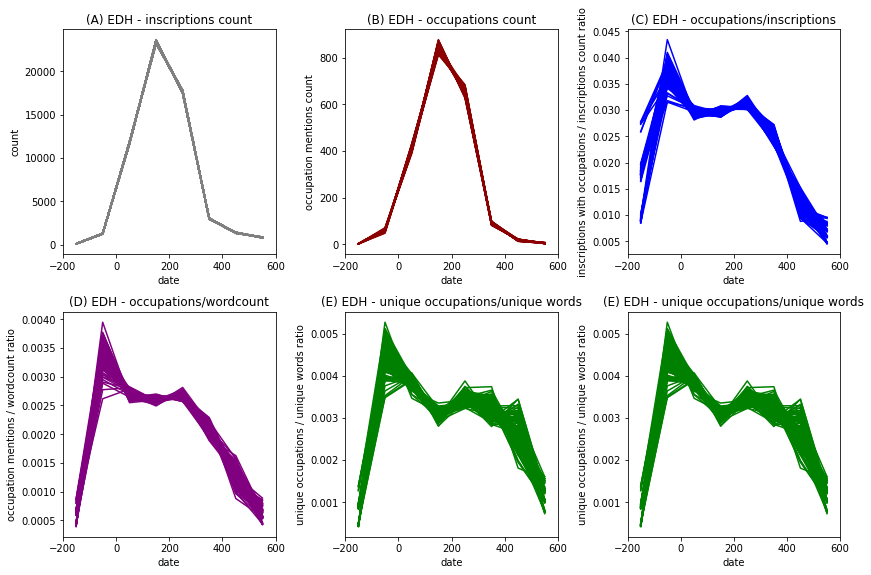

In [165]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]]  = plt.subplots(2, 3, figsize=(12, 8), tight_layout=True)

# ax1
plot_timeblocks_data(EDH_complete_simulations, ax=ax1, color="gray")
ax1.set_xlim(-200, 600)
ax1.set_xlabel("date")
ax1.set_ylabel("count")
ax1.set_title("(A) EDH - inscriptions count")

# ax2
plot_timeblocks_data(counts_data, ax=ax2, color="darkred")
ax2.set_xlim(-200, 600)
ax2.set_xlabel("date")
ax2.set_ylabel("occupation mentions count")
ax2.set_title("(B) EDH - occupations count")
      
# ax3
plot_timeblocks_data(occups_ins_ratio, ax=ax3, color="blue")
ax3.set_xlim(-200, 600)
ax3.set_xlabel("date")
ax3.set_ylabel("inscriptions with occupations / inscriptions count ratio")
ax3.set_title("(C) EDH - occupations/inscriptions")
      
# ax4
plot_timeblocks_data(TF_data, ax=ax4, color="purple")
ax4.set_xlim(-200, 600)
ax4.set_xlabel("date")
ax4.set_ylabel("occupation mentions / wordcount ratio")
ax4.set_title("(D) EDH - occupations/wordcount")

# ax5
plot_timeblocks_data(unique_occups, ax=ax5, color="green")
ax5.set_xlim(-200, 600)
ax5.set_xlabel("date")
ax5.set_ylabel("unique occupations / unique words ratio")
ax5.set_title("(E) EDH - unique occupations/unique words")

# ax6
plot_timeblocks_data(unique_occups, ax=ax6, color="green")
ax6.set_xlim(-200, 600)
ax6.set_xlabel("date")
ax6.set_ylabel("unique occupations / unique words ratio")
ax6.set_title("(E) EDH - unique occupations/unique words")

# Word numbers, character ngrams etc. 

In [171]:
from nltk import ngrams

In [176]:
list(set(["".join(ngram) for ngram in list(ngrams(string, 4))]))

['df f',
 'fsdf',
 'dsfs',
 ' vdf',
 'df d',
 'f fs',
 'f ds',
 ' dsf',
 'fs v',
 'dfdf',
 'sfs ',
 ' dfd',
 's vd',
 'fdf ',
 'vdf ',
 'sdf ',
 'f df',
 ' fsd']

In [199]:
def wordcount(timeblock_df):
    return timeblock_df["clean_text_interpretive_word"].astype(str).apply(lambda x: len(x.split())).sum()

def wordcount_avg(timeblock_df):
    return timeblock_df["clean_text_interpretive_word"].astype(str).apply(lambda x: len(x.split())).sum() / len(timeblock_df)

def charcount(timeblock_df):
    return timeblock_df["clean_text_interpretive_word"].astype(str).apply(lambda x: len(x)).sum()

def charcount_avr(timeblock_df):
    return timeblock_df["clean_text_interpretive_word"].astype(str).apply(lambda x: len(x)).sum() / len(timeblock_df)

def unique_words_weighted(timeblock_df):
    wordcount = timeblock_df["clean_text_interpretive_word"].astype(str).apply(lambda x: len(x.split())).sum()
    inscriptions_list = timeblock_df["clean_text_interpretive_word"].astype(str).tolist()
    unique_words = len(set(" ".join(inscriptions_list).split()))
    return unique_words / wordcount


def extrac_ngrams(inscription_text):
    char_ngrams = ["".join(ngram) for ngram in list(ngrams(str(inscription_text), 4))]
    return char_ngrams

def unique_ngrams_weighted(timeblock_df):
    ngrams_series = timeblock_df["clean_text_interpretive_word"].astype(str).apply(extrac_ngrams)
    all_ngrams = [el for sublist in ngrams_series for el in sublist]
    all_ngrams_unique = list(set(all_ngrams))
    charcount = timeblock_df["clean_text_interpretive_word"].astype(str).apply(lambda x: len(x)).sum()
    return len(all_ngrams_unique) / charcount

In [178]:
wordcounts_data = sim_data(EDH, 100, wordcount) 
wordcounts_data[0]

[((-200, -101), 4992),
 ((-100, -1), 18635),
 ((1, 100), 152670),
 ((101, 200), 324854),
 ((201, 300), 245260),
 ((301, 400), 43858),
 ((401, 500), 14532),
 ((501, 600), 8623)]

In [180]:
wordcounts_avg_data = sim_data(EDH, 100, wordcount_avg) 
wordcounts_avg_data[0]

[((-200, -101), 43.03448275862069),
 ((-100, -1), 14.423374613003096),
 ((1, 100), 13.078900025700333),
 ((101, 200), 13.85009592837348),
 ((201, 300), 13.88788221970555),
 ((301, 400), 14.527326929446836),
 ((401, 500), 10.439655172413794),
 ((501, 600), 10.503045066991474)]

In [189]:
charcounts_data = sim_data(EDH, 100, charcount) 
wordcounts_data[0]

[((-200, -101), 4992),
 ((-100, -1), 18635),
 ((1, 100), 152670),
 ((101, 200), 324854),
 ((201, 300), 245260),
 ((301, 400), 43858),
 ((401, 500), 14532),
 ((501, 600), 8623)]

In [ ]:
charcounts_avr_data = sim_data(EDH, 100, unique_ngrams_weighted)
charcounts_avr_data[0]

In [ ]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]]  = plt.subplots(2, 3, figsize=(12, 8), tight_layout=True)

# ax1
plot_timeblocks_data(EDH_complete_simulations, ax=ax1, color="gray")
ax1.set_xlim(-200, 600)
ax1.set_xlabel("date")
ax1.set_ylabel("count")
ax1.set_title("(A) EDH - inscriptions count")

# ax2
plot_timeblocks_data(counts_data, ax=ax2, color="darkred")
ax2.set_xlim(-200, 600)
ax2.set_xlabel("date")
ax2.set_ylabel("occupation mentions count")
ax2.set_title("(B) EDH - occupations count")